In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats
from scipy.stats import norm

import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

from sklearn import datasets, linear_model
import copy

# import EV_chargingstation_planning_inputdata_l2 as ECPinput
import cvxpy as cvx
import pdb

In [2]:
def load_chargePoint_data(filename, wantzero=True):
    """
        Load charge point data into python
        filename - string, specify file name
        wantzero - boolean, specify if want to keep zero energy sessions in data
    """
    
    df = pd.read_csv(filename)
    # Columns of information that exists in the csv file
    print("dataframe column: ")
    print(df.columns)
    
    # Extract columns that we are interested in
    cp_df = df[["MAC Address", "Start Date", "End Date", "User ID", "Energy (kWh)", 
                "Port Type", "Total Duration (hh:mm:ss)", "Charging Time (hh:mm:ss)"]]
    
    cp_len = len(cp_df)
    if not wantzero:
        
        # Delete zero entries
        cp_df = cp_df[(cp_df != 0).all(1)]
        print("\n")
        print("Deleted {} zero entries.".format(cp_len - len(cp_df)))
        
    else:
        
        # Fix NaN entries in End Date
        nan_number = 0
        for indx, row in cp_df.iterrows():
            if pd.isna(cp_df.loc[indx, "End Date"]):
                if not pd.isna(cp_df.loc[indx, "Start Date"]):

                    endDate = pd.to_datetime(cp_df.loc[indx, "Start Date"]) + \
                    pd.to_timedelta(cp_df.loc[indx, "Total Duration (hh:mm:ss)"])

                    cp_df.at[indx, "End Date"] = str(endDate)

                    nan_number += 1
        print("\n")
        print("Fixed {} NaN values".format(nan_number))
    
    return cp_df 

In [83]:
csv_file = 'chargpoint_0116_0216_Data.csv'
cp_df = load_chargePoint_data(csv_file, wantzero=False)
cp_df

dataframe column: 
Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee',
       'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID',
       'Start SOC', 'End SOC', 'County', 'System S/N', 'Model Number'],
      dtype='object')


Deleted 51 zero entries.


,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:2010,2019-02-16 19:15:09,2019-02-17 11:00:12,NaN,54.983,Level 2,15:45:03,08:11:18
1,0024:B100:0002:2010,2019-02-16 20:40:04,2019-02-16 23:43:27,797543,11.771,Level 2,03:03:21,03:03:12
2,0024:B100:0002:1302,2019-02-16 14:50:37,2019-02-16 16:37:54,1782891,4.322,Level 2,01:47:22,01:47:08
3,0024:B100:0002:1280,2019-02-16 13:12:02,2019-02-16 16:16:58,1912621,5.859,Level 2,03:04:56,01:50:30
4,0024:B100:0002:2010,2019-02-16 12:28:36,2019-02-16 14:26:06,418203,8.513,Level 2,01:57:30,01:17:29
5,0024:B100:0002:1302,2019-02-16 09:25:42,2019-02-16 13:25:08,3868531,13.005,Level 2,03:59:24,03:59:15
6,0024:B100:0002:2010,2019-02-16 11:45:21,2019-02-16 13:05:33,3790361,0.918,Level 2,01:20:12,00:27:00
7,0024:B100:0002:2010,2019-02-16 10:36:54,2019-02-16 11:53:19,418203,8.744,Level 2,01:16:23,01:16:13
8,0024:B100:0002:2010,2019-02-16 09:16:09,2019-02-16 10:29:18,392733,4.122,Level 2,01:13:13,01:12:58
9,0024:B100:0002:12F1,2019-02-15 21:57:39,2019-02-16 00:25:28,323083,0.162,Level 2,02:27:49,00:26:55


# Data visualization

In [84]:
x_data_chargeTime = pd.to_timedelta(cp_df["Charging Time (hh:mm:ss)"]).dt.total_seconds()
y_data_energy = pd.to_numeric(cp_df["Energy (kWh)"])

## Charging Duration

Text(0, 0.5, 'Frequency')

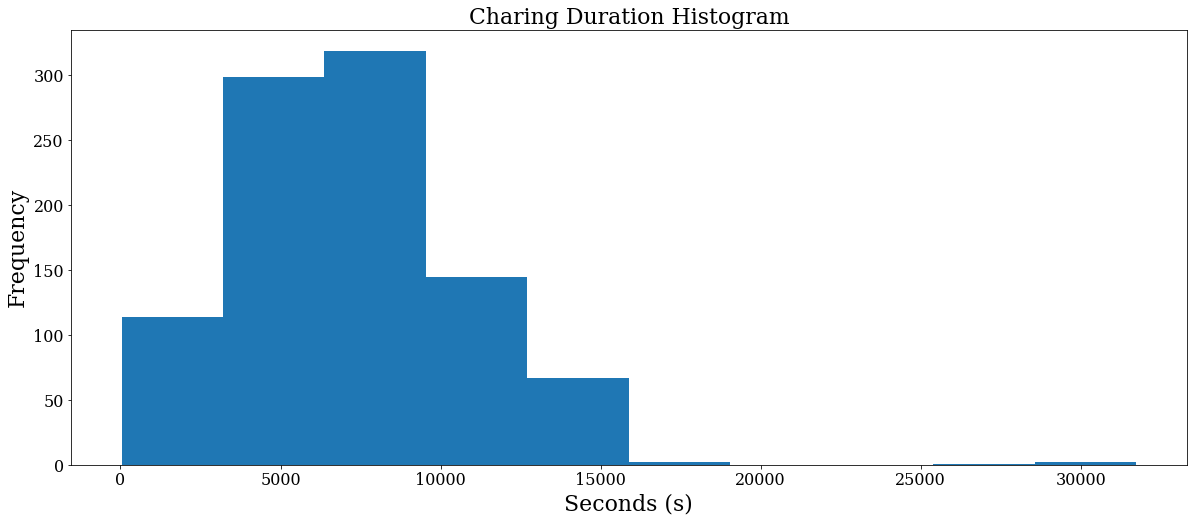

In [85]:
font = {'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,8))
plt.hist(x_data_chargeTime)
plt.title("Charing Duration Histogram", fontsize=22)
plt.xlabel("Seconds (s)", fontsize=22)
plt.ylabel("Frequency", fontsize=22)


# plotly_fig = tls.mpl_to_plotly( fig )
# py.iplot(plotly_fig, filename='mpl-basic-histogram')


## Session Length - Load data from CP database directly

Text(0, 0.5, 'Cumulative Percentage (%)')

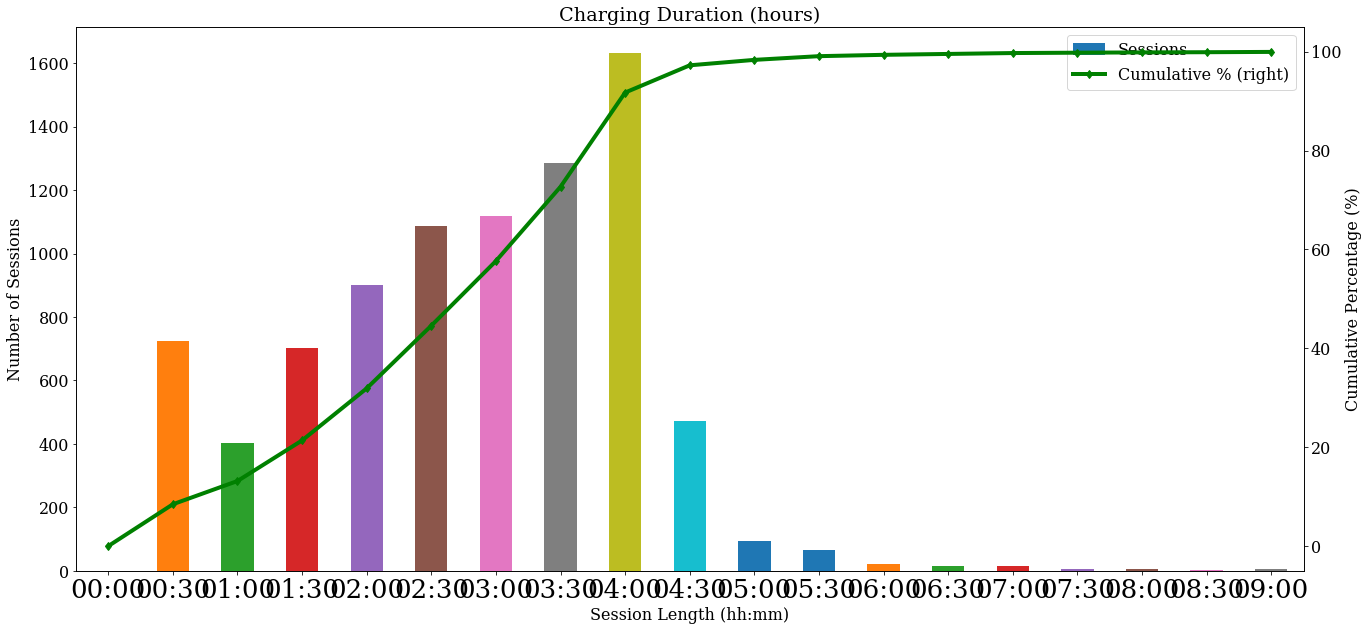

In [87]:
sl_df = pd.read_csv("session_length.csv") #plot data download directly from CP
sl_df = sl_df.iloc[:19, :]
ax = sl_df.plot.bar(x="Session Length (hh:mm)", y="Sessions", figsize=(22,10))
ax.set_xticklabels(sl_df["Session Length (hh:mm)"], fontsize=26)
ax.set_ylabel("Number of Sessions")
ax.set_title("Charging Duration (hours)")

ax2 = sl_df.plot.line(x="Session Length (hh:mm)", y="Cumulative %", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True)
ax2.set_ylabel("Cumulative Percentage (%)")
# plt.savefig("output_figures/session_length_CP.pdf")

## EV Market Shares - Essencially we need weighted average battery sizes of 7.2 and 3.6 EVs

In [88]:
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)

In [89]:
ev_sales_df

,2018,2017,2016,2015,2014,Total Sales,Charging Power (kW),Battery (kWh),Total Battery (kWh)
Tesla Model 3,13782,1764,0,0,0,15546,7.2,50.000000,7.773000e+05
Toyota Prius Prime + PHEV,27595,20936,2474,4191,13264,68460,3.6,7.674806,5.254172e+05
Tesla Model X,26100,21315,18223,214,0,65852,7.2,75.000000,4.938900e+06
Tesla Model S,25745,27060,28896,25202,16689,123592,7.2,70.000000,8.651440e+06
Honda Clarity PHEV,18602,1121,0,0,0,19723,7.2,25.500000,5.029365e+05
Chevy Volt,18306,20349,24739,15393,18805,97592,3.6,18.400000,1.795693e+06
Chevy Bolt,18019,23297,579,0,0,41895,7.2,60.000000,2.513700e+06
Nissan Leaf,14715,11230,14006,17269,30200,87420,7.2,35.000000,3.059700e+06
Ford Fusion Energi,8074,9632,15938,9750,11550,54944,3.6,7.600000,4.175744e+05
Ford C-max Energi,582,8140,7957,7591,8433,32703,3.6,7.600000,2.485428e+05


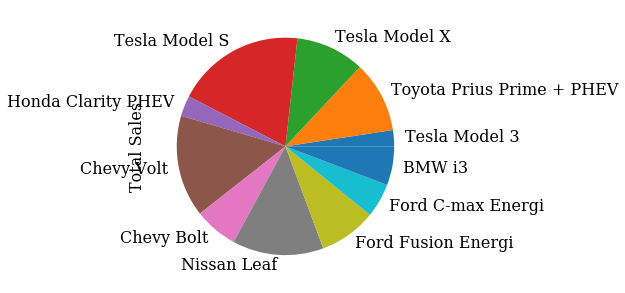

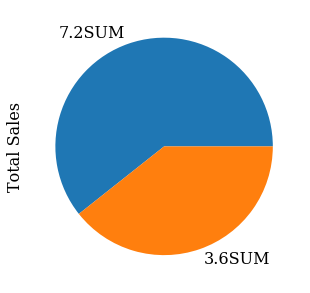

In [90]:
font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)
ev_sales_df.iloc[:-2,:].plot.pie(y="Total Sales", figsize=(5,5), legend=False)
ev_sales_df.loc[["7.2SUM", "3.6SUM"],:].plot.pie(y="Total Sales", figsize=(5,5), legend=False)

# Quantile Regression

In [10]:
x_data_chargeTime_copy = copy.deepcopy(x_data_chargeTime)
y_data_energy_copy = copy.deepcopy(y_data_energy)

x_data_chargeTime_copy = x_data_chargeTime_copy.dropna()
y_data_energy_copy = y_data_energy_copy.dropna()

x_data_chargeTime_copy = x_data_chargeTime_copy.values
y_data_energy_copy = y_data_energy_copy.values

In [11]:
font = {'family' : 'serif',
        'size'   : 20}

matplotlib.rc('font', **font)

def quantile_regression(x_data, y_data, q_list, loc, comments):
    """
        From charging rates extract quantile and perform linear regression
        x_data - numpy array
        y_data - numpy array
        q_list - list of quantiles, [0, 100]
        loc - list of boolean, specify the needed data is above the percentile of below the percentile
                True for above
        comments - list of string, for extra comments on legends
    """
    plt.figure(figsize=(20,8))
    
    charge_rate_list = y_data / x_data
    
    loc_word = ["above", "below"]
    
    
    for idx, q in enumerate(q_list):
        
        if loc[idx]:
            # Select values that are above specified quantile
            x_data_q = x_data[np.where(charge_rate_list > np.percentile(charge_rate_list, q))]
            y_data_q = y_data[np.where(charge_rate_list > np.percentile(charge_rate_list, q))]
            loc_idx = 0
        
        else:
            x_data_q = x_data[np.where(charge_rate_list < np.percentile(charge_rate_list, q))]
            y_data_q = y_data[np.where(charge_rate_list < np.percentile(charge_rate_list, q))]
            loc_idx = 1
            
        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(x_data_q.reshape(-1,1), y_data_q.reshape(-1,1))
        
        # The coefficients
        print("Coefficients: " + str(regr.coef_[0,0]) + ", {} {} percentile.".format(loc_word[loc_idx], q))
    
        # Plot regression line
        # plt.scatter(x_data, y_data)
        x_regr = np.linspace(0, 34000, 1000).reshape(-1,1)
        y_regr = regr.predict(x_regr)
        if comments[idx] == "":
            plt.plot(x_regr, y_regr, label="{} {} Percentile Regression Line, Coef={}".format(loc_word[loc_idx], 
                                                                                              q, round(regr.coef_[0,0], 7)))
        else:
            plt.plot(x_regr, y_regr, label="{} {} Percentile Regression Line, Coef={}, ".format(loc_word[loc_idx], 
                                                                                                q, round(regr.coef_[0,0], 7)) + comments[idx])

    # Plot original data
    plt.scatter(x_data, y_data, label="Original Data")
    plt.legend(fontsize=16)
    plt.xlabel("Seconds (s)")
    plt.ylabel("Energy Consumption (kwh)")
    plt.show()

Coefficients: 0.0005231918827516106, below 15 percentile.
Coefficients: 0.0009540908267482915, below 80 percentile.
Coefficients: 0.0016114006387577806, above 50 percentile.
Coefficients: 0.0019497005442590178, above 90 percentile.


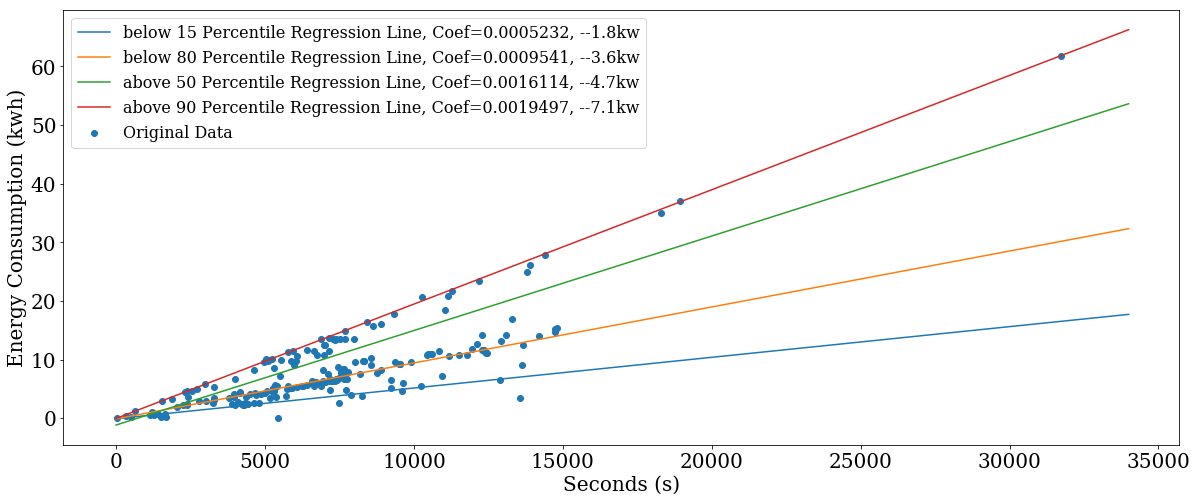

In [12]:
quantile_regression(x_data_chargeTime_copy, y_data_energy_copy, q_list=[15, 80, 50, 90], 
                    loc=[False, False, True, True], comments=["--1.8kw", "--3.6kw", "--4.7kw", "--7.1kw"])

# Idle time

In [13]:
idleTime_list = pd.to_timedelta(cp_df["Total Duration (hh:mm:ss)"]).dt.total_seconds() \
- pd.to_timedelta(cp_df["Charging Time (hh:mm:ss)"]).dt.total_seconds().values
idlegap = 3600

In [14]:
x_data_copy_idle = x_data_chargeTime_copy[np.where(idleTime_list > idlegap)]
y_data_copy_idle = y_data_energy_copy[np.where(idleTime_list > idlegap)]

Coefficients: 0.0019523642183000606, above 90 percentile.
Coefficients: 0.0011131472948956564, below 70 percentile.


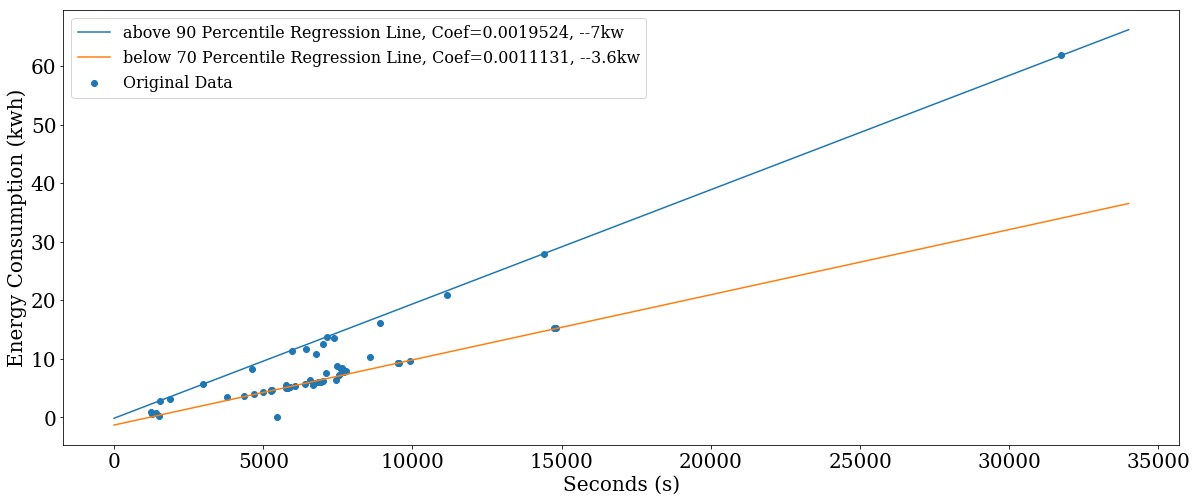

In [15]:
quantile_regression(x_data_copy_idle, y_data_copy_idle, [90, 70], [True, False], ["--7kw", "--3.6kw"])

# Aggregate Demands

In [76]:
csv_file = 'chargpoint_0116_0216_Data.csv'
cp_df = load_chargePoint_data(csv_file, wantzero=True)

dataframe column: 
Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee',
       'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID',
       'Start SOC', 'End SOC', 'County', 'System S/N', 'Model Number'],
      dtype='object')


Fixed 0 NaN values


In [77]:
# Take daylight saving into acount and leave out rows that erroneous
cp_df = cp_df.loc[pd.to_timedelta(cp_df["Total Duration (hh:mm:ss)"]) + dt.timedelta(hours=1) > \
                  pd.to_timedelta(pd.to_datetime(cp_df["End Date"]) - pd.to_datetime(cp_df["Start Date"]))]

In [78]:
cp_df

,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:2010,2019-02-16 19:15:09,2019-02-17 11:00:12,NaN,54.983,Level 2,15:45:03,08:11:18
1,0024:B100:0002:2010,2019-02-16 20:40:04,2019-02-16 23:43:27,797543,11.771,Level 2,03:03:21,03:03:12
2,0024:B100:0002:1302,2019-02-16 14:50:37,2019-02-16 16:37:54,1782891,4.322,Level 2,01:47:22,01:47:08
3,0024:B100:0002:1280,2019-02-16 13:12:02,2019-02-16 16:16:58,1912621,5.859,Level 2,03:04:56,01:50:30
4,0024:B100:0002:2010,2019-02-16 12:28:36,2019-02-16 14:26:06,418203,8.513,Level 2,01:57:30,01:17:29
5,0024:B100:0002:1302,2019-02-16 09:25:42,2019-02-16 13:25:08,3868531,13.005,Level 2,03:59:24,03:59:15
6,0024:B100:0002:2010,2019-02-16 11:45:21,2019-02-16 13:05:33,3790361,0.918,Level 2,01:20:12,00:27:00
7,0024:B100:0002:2010,2019-02-16 10:36:54,2019-02-16 11:53:19,418203,8.744,Level 2,01:16:23,01:16:13
8,0024:B100:0002:2010,2019-02-16 09:16:09,2019-02-16 10:29:18,392733,4.122,Level 2,01:13:13,01:12:58
9,0024:B100:0002:12F1,2019-02-15 21:57:39,2019-02-16 00:25:28,323083,0.162,Level 2,02:27:49,00:26:55


## Before aggregating: Utilization, duration, and session length

In [80]:
# extract data and plot data through caluclation
cp_df_2018_2019 = cp_df[pd.to_datetime(cp_df["Start Date"]) > dt.datetime(2019, 1, 15)]

In [81]:
tot_plugInLength = pd.to_timedelta(cp_df_2018_2019["Total Duration (hh:mm:ss)"]).sum()  #total plug in length
tot_chargingLength = pd.to_timedelta(cp_df_2018_2019["Charging Time (hh:mm:ss)"]).sum() #total charging length
actual_charging_rate = tot_chargingLength/tot_plugInLength
utilization_rate = tot_chargingLength.total_seconds()/(dt.datetime(2019,2,16) - dt.datetime(2019,1,16)).total_seconds()/12
print("The charging over parking ratio is: ", actual_charging_rate, ", due to CP is implementing pricing policy.")
print("The utilization rate is: ", utilization_rate, ", from 2019.1.16 to 2019.2.16.")

The charging over parking ratio is:  0.7306631016307585 , due to CP is implementing pricing policy.
The utilization rate is:  0.2111795910493827 , from 2019.1.16 to 2019.2.16.


### Total Duration

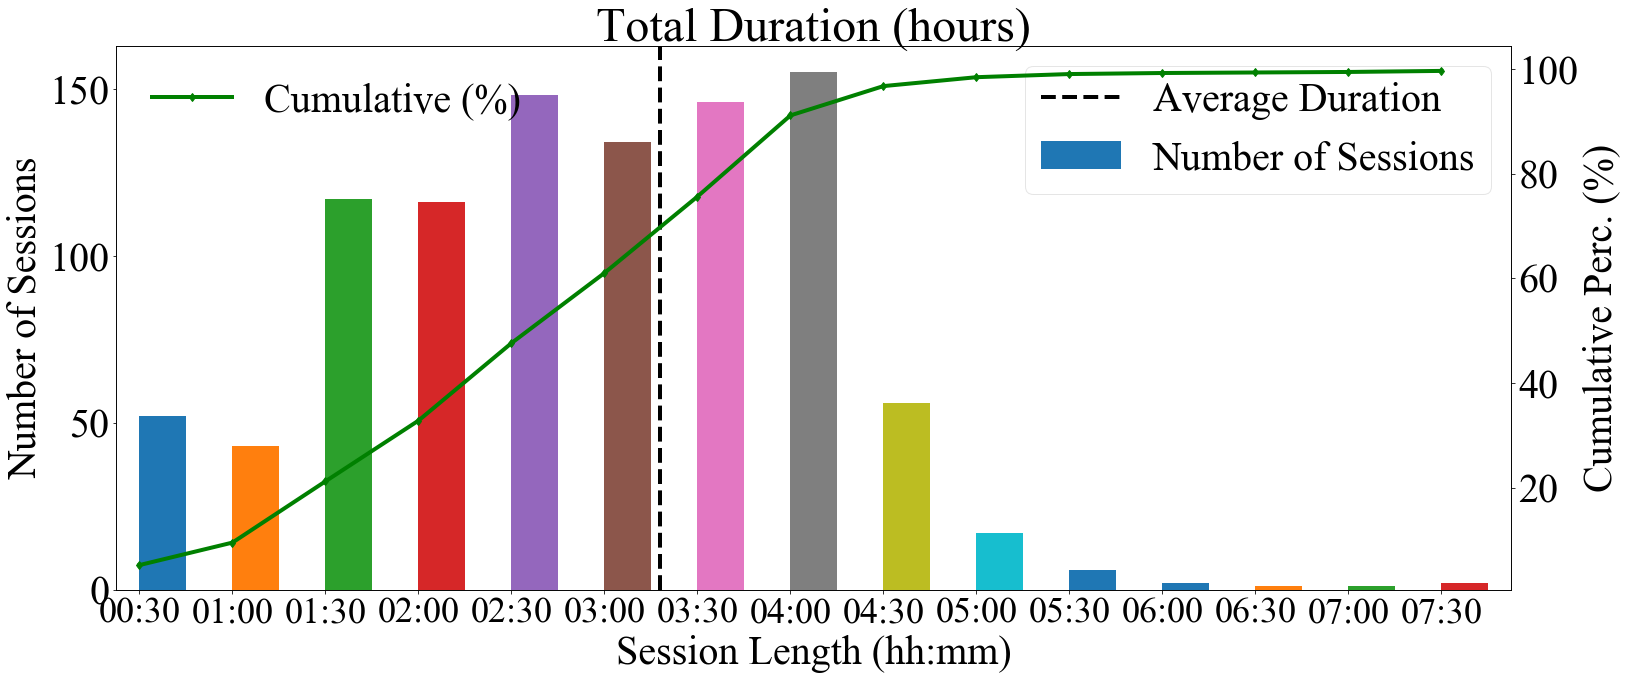

In [91]:
test = np.ceil(pd.to_timedelta(cp_df_2018_2019["Total Duration (hh:mm:ss)"]).dt.total_seconds()/1800).value_counts()
test = test.sort_index(axis=0)
test_df = pd.concat([(100*test.cumsum()/test.sum())[:15], test[:15], sl_df["Session Length (hh:mm)"][1:16]], axis=1)
test_df.columns = ["Cumulative Percentage (%)", "Number of Sessions", "Session Length (hh:mm)"]

# set up plot specs
font = {'family' : 'Times New Roman',
        'size'   : 40}

matplotlib.rc('font', **font)
# average duration length
ave_duration = (test_df["Number of Sessions"]*test_df.index).sum()/test_df["Number of Sessions"].sum()

# plot results
ax = test_df.plot.bar(x="Session Length (hh:mm)", y="Number of Sessions", \
                      figsize=(25, 10), align="edge")
# plot average duration line
ax.axvline(ave_duration, color='k', linestyle='--', linewidth=4, label="Average Duration")
# plot cumulative percentage
ax.set_xticklabels(test_df["Session Length (hh:mm)"], fontsize=36)
ax.set_ylabel("Number of Sessions")
ax.set_title("Total Duration (hours)")

ax2 = test_df.plot.line(x="Session Length (hh:mm)", y="Cumulative Percentage (%)", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True, 
                        label="Cumulative (%)")
ax2.set_ylabel("Cumulative Perc. (%)")
ax.legend(loc="best", framealpha=0.5)
ax2.legend(loc="best", framealpha=0)
# plt.savefig("output_figures/session_total_duration_calc.pdf")

### Charging Duration

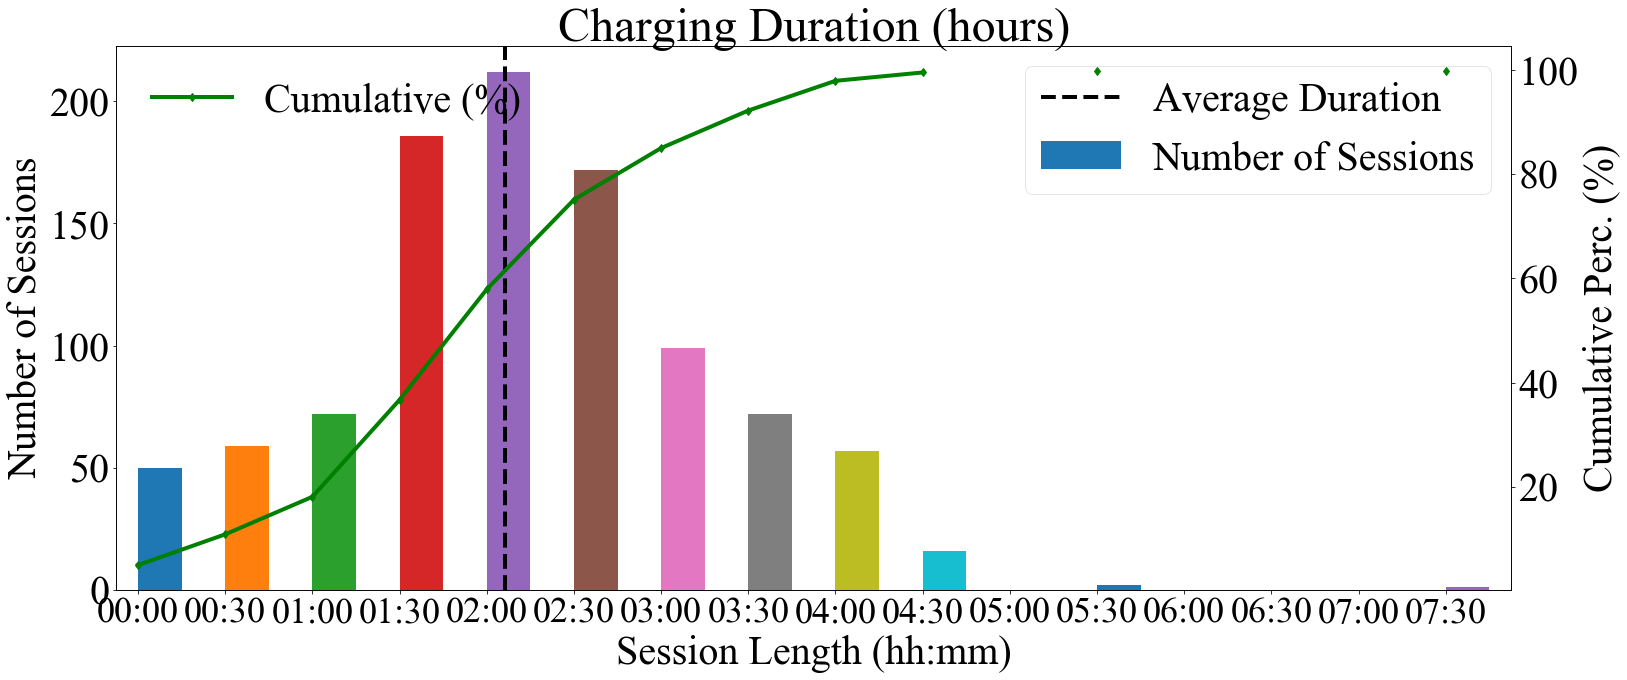

In [92]:
test = np.ceil(pd.to_timedelta(cp_df_2018_2019["Charging Time (hh:mm:ss)"]).dt.total_seconds()/1800).value_counts()
test = test.sort_index(axis=0)
test_df = pd.concat([(100*test.cumsum()/test.sum())[:15], test[:15], sl_df["Session Length (hh:mm)"][:16]], axis=1)
test_df.columns = ["Cumulative Percentage (%)", "Number of Sessions", "Session Length (hh:mm)"]

# set up plot specs
font = {'family' : 'Times New Roman',
        'size'   : 40}

matplotlib.rc('font', **font)
# average duration length
ave_duration = (test_df["Number of Sessions"]*test_df.index).sum()/test_df["Number of Sessions"].sum()

# plot results
ax = test_df.plot.bar(x="Session Length (hh:mm)", y="Number of Sessions", \
                      figsize=(25, 10), align="edge")
# plot average duration line
ax.axvline(ave_duration, color='k', linestyle='--', linewidth=4, label="Average Duration")
# plot cumulative percentage
ax.set_xticklabels(test_df["Session Length (hh:mm)"], fontsize=36)
ax.set_ylabel("Number of Sessions")
ax.set_title("Charging Duration (hours)")

ax2 = test_df.plot.line(x="Session Length (hh:mm)", y="Cumulative Percentage (%)", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True, 
                        label="Cumulative (%)")
ax2.set_ylabel("Cumulative Perc. (%)")
ax.legend(loc="best", framealpha=0.5)
ax2.legend(loc="best", framealpha=0)
# plt.savefig("output_figures/session_charging_duration_calc.pdf")

# Create daily profile

In [93]:
cp_df

,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:2010,2019-02-16 19:15:09,2019-02-17 11:00:12,NaN,54.983,Level 2,15:45:03,08:11:18
1,0024:B100:0002:2010,2019-02-16 20:40:04,2019-02-16 23:43:27,797543,11.771,Level 2,03:03:21,03:03:12
2,0024:B100:0002:1302,2019-02-16 14:50:37,2019-02-16 16:37:54,1782891,4.322,Level 2,01:47:22,01:47:08
3,0024:B100:0002:1280,2019-02-16 13:12:02,2019-02-16 16:16:58,1912621,5.859,Level 2,03:04:56,01:50:30
4,0024:B100:0002:2010,2019-02-16 12:28:36,2019-02-16 14:26:06,418203,8.513,Level 2,01:57:30,01:17:29
5,0024:B100:0002:1302,2019-02-16 09:25:42,2019-02-16 13:25:08,3868531,13.005,Level 2,03:59:24,03:59:15
6,0024:B100:0002:2010,2019-02-16 11:45:21,2019-02-16 13:05:33,3790361,0.918,Level 2,01:20:12,00:27:00
7,0024:B100:0002:2010,2019-02-16 10:36:54,2019-02-16 11:53:19,418203,8.744,Level 2,01:16:23,01:16:13
8,0024:B100:0002:2010,2019-02-16 09:16:09,2019-02-16 10:29:18,392733,4.122,Level 2,01:13:13,01:12:58
9,0024:B100:0002:12F1,2019-02-15 21:57:39,2019-02-16 00:25:28,323083,0.162,Level 2,02:27:49,00:26:55


In [94]:
def extract_dayData(month, day):
    """
        Extract day utilization data from specified day range
        Note: this function extract data from three years
                so only month and day numbers are needed 
        day_start, day_end - datetime object
    """
    
    years_list = [2019]
    df_tmp = list()
    
    for y in range(len(years_list)):
        
        day_start = dt.datetime(years_list[y], month, day)
        day_end = day_start + dt.timedelta(days=1)

        df_tmp.append(cp_df.loc[(pd.to_datetime(cp_df["Start Date"])>day_start) \
                            & (pd.to_datetime(cp_df["Start Date"])<day_end)])
    
    return pd.concat(df_tmp)

In [95]:
# def datetime2dayidx(starttime, endtime):
#     """
#         Compute tick point index of the day based on the input time
#         Using both datetime objects to determine if EV stays overnight
#         starttime, endtime - datetime object
#     """
# #     if starttime.minute < 30:
# #         starttime_idx = starttime.hour*4 
# #     else:
# #         starttime_idx = starttime.hour*4 + 2
# #     if endtime.minute < 30:
# #         endtime_idx = endtime.hour*4 + 2
# #     else:
# #         endtime_idx = endtime.hour*4 + 4
    
#     if starttime.hour == endtime.hour:
#         starttime_idx = starttime.hour*4
#         endtime_idx = endtime.hour*4+2
#     elif starttime.hour == endtime.hour-1:
#         starttime_idx = starttime.hour*4
#         endtime_idx = endtime.hour*4
#     else:
#         starttime_idx = starttime.hour*4+2
#         endtime_idx = endtime.hour*4
        
#     if starttime.hour > endtime.hour:
#         return starttime_idx, endtime_idx+96
#     else:
#         return starttime_idx, endtime_idx

def datetime2dayidx(starttime, endtime):
    """
        Compute tick point index of the day based on the input time
        Using both datetime objects to determine if EV stays overnight
        starttime, endtime - datetime object
    """
    def datetime2dayidx_helper(time):
        if time.minute < 7.5:
            extra_tick = 0
        elif (time.minute > 7.5) & (time.minute < 22.5):
            extra_tick = 1
        elif (time.minute > 22.5) & (time.minute < 37.5):
            extra_tick = 2
        elif (time.minute > 37.5) & (time.minute < 52.5):
            extra_tick = 3
        else:
            extra_tick = 4
        return extra_tick
    
    extra_tick_start = datetime2dayidx_helper(starttime)
    extra_tick_end = datetime2dayidx_helper(endtime)
    
    starttime_idx = starttime.hour*4 + extra_tick_start
    endtime_idx = endtime.hour*4 + extra_tick_end
    if starttime.hour > endtime.hour:
        return starttime_idx, endtime_idx+96
    else:
        return starttime_idx, endtime_idx

# def datetime2dayidx(starttime, endtime):
#     """
#         Compute tick point index of the day based on the input time
#         Using both datetime objects to determine if EV stays overnight
#         starttime, endtime - datetime object
#     """
# #     if starttime.minute < 30:
# #         starttime_idx = starttime.hour*4 
# #     else:
# #         starttime_idx = starttime.hour*4 + 2
# #     if endtime.minute < 30:
# #         endtime_idx = endtime.hour*4 + 2
# #     else:
# #         endtime_idx = endtime.hour*4 + 4
#     starttime_idx = starttime.hour*4 
#     endtime_idx = endtime.hour*4 + 4
        
#     if starttime.hour > endtime.hour:
#         return starttime_idx, endtime_idx+96
#     else:
#         return starttime_idx, endtime_idx



# Visualization for demands based on one day


In [15]:
dayofInterest_start = dt.datetime(2019, 1, 18, 0, 0, 0)
dayofInterest_end = dt.datetime(2019, 1, 19, 0, 0, 0)
cp_df_baseline = cp_df[pd.to_datetime(cp_df.loc[:, "Start Date"]) > dayofInterest_start]
cp_df_baseline = cp_df_baseline[pd.to_datetime(cp_df.loc[:, "End Date"]) < dayofInterest_end]
cp_df_baseline = cp_df_baseline.sort_values(by=["Start Date"])
cp_df_baseline

/Users/janton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
133,0024:B100:0002:2010,2019-01-18 01:41:38,2019-01-18 05:28:03,648859.0,9.244,Level 2,03:46:25,02:38:54
127,0024:B100:0002:2010,2019-01-18 07:26:24,2019-01-18 10:43:14,2144341.0,10.707,Level 2,03:16:49,03:16:40
122,0024:B100:0002:1302,2019-01-18 07:30:13,2019-01-18 11:31:31,827095.0,11.667,Level 2,04:01:18,03:25:04
131,0024:B100:0002:1280,2019-01-18 07:39:47,2019-01-18 09:06:34,1782891.0,3.488,Level 2,01:26:45,01:26:24
132,0024:B100:0002:2342,2019-01-18 08:01:33,2019-01-18 09:06:24,1383911.0,0.485,Level 2,01:04:51,00:18:55
123,0024:B100:0002:1280,2019-01-18 08:18:02,2019-01-18 11:24:10,3882261.0,18.434,Level 2,03:06:08,03:04:10
119,0024:B100:0002:1302,2019-01-18 08:24:44,2019-01-18 12:20:29,1260731.0,8.324,Level 2,03:55:44,02:07:17
129,0024:B100:0002:1EFF,2019-01-18 08:25:21,2019-01-18 10:26:21,497861.0,6.168,Level 2,02:01:00,01:56:47
126,0024:B100:0002:12F1,2019-01-18 08:31:54,2019-01-18 11:10:39,1141501.0,3.580,Level 2,02:38:45,01:12:34
117,0024:B100:0002:2342,2019-01-18 08:33:26,2019-01-18 13:10:09,2347071.0,24.991,Level 2,04:36:43,03:49:55


([<matplotlib.axis.XTick at 0x1a289399b0>,
 <a list of 12 Text xticklabel objects>)

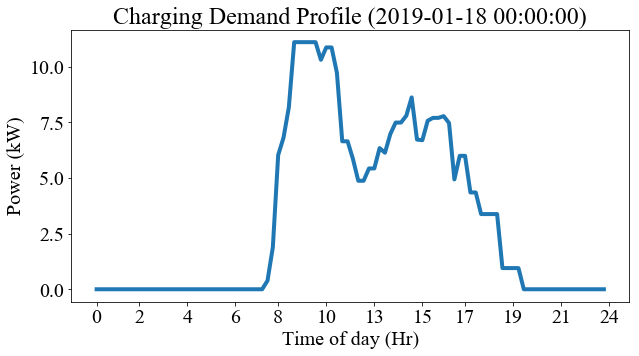

In [16]:
powProf_baseline = np.zeros(96)
for act_idx in cp_df_baseline.index:
    # Identify start time and end time
    start_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "Start Date"])
    end_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "End Date"])
    if start_date.hour > 7:
        if (end_date.hour < 22) and (end_date.day == start_date.day):
            
            # Ensure no over night staying
            act_startTime, act_endTime = datetime2dayidx(start_date, end_date)
            # Generate power consumption of time
            act_charDuration = pd.to_timedelta(cp_df_baseline.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/15.0/60
            
            if act_charDuration != 0.0:
                # Ensure charging activity
                act_charRate = cp_df_baseline.loc[act_idx, "Energy (kWh)"] \
                / (pd.to_timedelta(cp_df_baseline.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/15.0/60)
                act_powerTemp = np.zeros(96)
                np.put(act_powerTemp, np.arange(act_startTime, act_endTime), act_charRate)
                powProf_baseline += act_powerTemp

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,5))
plt.plot(range(96), powProf_baseline, linewidth=4)
plt.title("Charging Demand Profile ({})".format(dayofInterest_start))
plt.xlabel("Time of day (Hr)")
plt.ylabel("Power (kW)")
plt.xticks(np.linspace(0, 96, 12, dtype="int"), np.linspace(0, 24, 12, dtype="int"))

# plt.savefig("../visualization/vis_chargingProfile.pdf")

# Visualization for demands based on specified days

/Users/janton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



([<matplotlib.axis.XTick at 0x1a2fc24e48>,
 <a list of 12 Text xticklabel objects>)

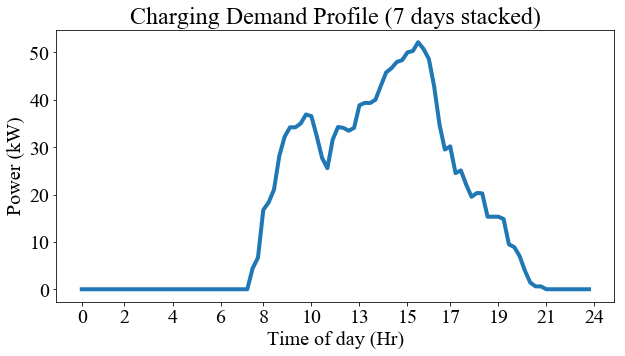

In [97]:
powProf_baseline = np.zeros(96)

for day_id in range(7):
    dayofInterest_start = dt.datetime(2019, 1, 16+day_id, 0, 0, 0)
    dayofInterest_end = dt.datetime(2019, 1, 17+day_id, 0, 0, 0)
    cp_df_baseline = cp_df[pd.to_datetime(cp_df.loc[:, "Start Date"]) > dayofInterest_start]
    cp_df_baseline = cp_df_baseline[pd.to_datetime(cp_df.loc[:, "End Date"]) < dayofInterest_end]
    cp_df_baseline = cp_df_baseline.sort_values(by=["Start Date"])
    for act_idx in cp_df_baseline.index:
        # Identify start time and end time
        start_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "Start Date"])
        end_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "End Date"])
        if start_date.hour > 7:
            if (end_date.hour < 22) and (end_date.day == start_date.day):

                # Ensure no over night staying
                act_startTime, act_endTime = datetime2dayidx(start_date, end_date)
                # Generate power consumption of time
                act_charDuration = pd.to_timedelta(cp_df_baseline.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/15.0/60

                if act_charDuration != 0.0:
                    # Ensure charging activity
                    act_charRate = cp_df_baseline.loc[act_idx, "Energy (kWh)"] \
                    / (pd.to_timedelta(cp_df_baseline.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/15.0/60)
                    act_powerTemp = np.zeros(96)
                    np.put(act_powerTemp, np.arange(act_startTime, act_endTime), act_charRate)
                    powProf_baseline += act_powerTemp

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,5))
plt.plot(range(96), powProf_baseline, linewidth=4)
plt.title("Charging Demand Profile (7 days stacked)")
plt.xlabel("Time of day (Hr)")
plt.ylabel("Power (kW)")
plt.xticks(np.linspace(0, 96, 12, dtype="int"), np.linspace(0, 24, 12, dtype="int"))

# plt.savefig("../visualization/vis_chargingProfile.pdf")

# Function to extract data

In [108]:
def ee227_extrData(cp_df, ee227c_df):
    """
    cp_df is the raw dataframe trying to extract data out of
    ee227c_df is the desired dateframe to put into
    """
    for act_idx in cp_df.index:

        # check if end time is before specified
        end_hr = 22 # station shuts down at 10pm
        start_hr = 7 # station starts at 7am
        
        act_end_time = dt.datetime.strptime(cp_df.loc[act_idx, "End Date"], "%Y-%m-%d %H:%M:%S")
        act_arr_time = dt.datetime.strptime(cp_df.loc[act_idx, "Start Date"], "%Y-%m-%d %H:%M:%S")

        if act_end_time < dt.datetime(act_end_time.year, act_end_time.month, act_end_time.day, end_hr) \
        and act_arr_time > dt.datetime(act_end_time.year, act_end_time.month, act_end_time.day, start_hr):

            act_tot_duration = (act_end_time - act_arr_time).total_seconds()/60/60

            act_arr_time = act_arr_time.hour + act_arr_time.minute/60 # convert arrival time to format

            # Charging duration and charging rate
            e_delivered = cp_df.loc[act_idx, "Energy (kWh)"] 
            act_char_dur = pd.to_timedelta(cp_df.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/60/60
            # Determine battery size
            charging_rate = e_delivered/act_char_dur
#             if e_delivered > 40:
            if False:
                # assign to 7.2 kW catagory
                battery_cap = 75 # battery_cap is used to cap the energy upper bound
                act_power_max = 7.2
#             elif charging_rate > 4.2:
            elif False:
                # assign to 7.2 kW catagory
                battery_cap = large_batSize # battery_cap is used to cap the energy upper bound
                act_power_max = 7.2
            else:
                # assign to 3.6 kW catagory
                battery_cap = small_batSize    
                act_power_max = 7.2
                if battery_cap < e_delivered:
                    battery_cap = large_batSize

            act_soc_need = e_delivered/battery_cap
            if act_soc_need > 1:
                print("Needed SOC greater than 1.")
                pdb.set_trace()
            act_soc_init = 0.95 - act_soc_need
            if act_soc_init < 0:
                act_soc_init = 0

            act_overstay_dur = act_tot_duration - act_char_dur
            if act_tot_duration <  act_overstay_dur:
                
                print("total duration: {}".format(act_tot_duration))
                print("Charging duration: {} \n".format(act_char_dur))

            df_temp = pd.DataFrame([[act_arr_time, act_soc_init, 0.95, battery_cap, 
                                     act_char_dur, act_overstay_dur, act_power_max]], 
                                   columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                            "duration", "overstay_duration", "power_max"])
            ee227c_df = ee227c_df.append(df_temp)
    return ee227c_df

# Extract data for baseline one day

In [99]:
ee227c_df_base = pd.DataFrame(columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                        "duration", "overstay_duration", "power_max"])
# Extract battery size
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)
large_batSize = ev_sales_df.loc["7.2SUM","Battery (kWh)"]
small_batSize = ev_sales_df.loc["3.6SUM","Battery (kWh)"]

ee227c_df_base = ee227_extrData(cp_df_baseline, ee227c_df_base)

# Verify if duration can satisfy the need
act_unqualify_numb = ((ee227c_df_base.loc[:, "soc_need"] * ee227c_df_base.loc[:, "batt_cap"] / ee227c_df_base.loc[:, "power_max"]) > ee227c_df_base.loc[:, "duration"]).sum()
print("Number of unqualified activities are {}.".format(act_unqualify_numb))
ee227c_df_base = ee227c_df_base[(ee227c_df_base.loc[:, "soc_need"] * ee227c_df_base.loc[:, "batt_cap"] / ee227c_df_base.loc[:, "power_max"]) < ee227c_df_base.loc[:, "duration"]]

# Sort dataframe based on event time order and filter duration
ee227c_df_base = ee227c_df_base.sort_values(by=["arr_time"])
ee227c_df_base = ee227c_df_base[ee227c_df_base["duration"] > 0.3]
# ee227c_df_base.to_csv("../real_act_data_1day.csv")

Number of unqualified activities are 21.


# Extract data across couple days

In [109]:
# for simplicity as well as prior consensus, time discretization is 15 min.
# Initialize dataframe
ee227c_df_grand = pd.DataFrame(columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                        "duration", "overstay_duration", "power_max"])

# Extract battery size
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)
large_batSize = ev_sales_df.loc["7.2SUM","Battery (kWh)"]
small_batSize = ev_sales_df.loc["3.6SUM","Battery (kWh)"]

ee227c_df_grand = ee227_extrData(cp_df.dropna(), ee227c_df_grand)

In [112]:
# Verify if duration can satisfy the need
act_unqualify_numb = ((ee227c_df_grand.loc[:, "soc_need"] * ee227c_df_grand.loc[:, "batt_cap"] / ee227c_df_grand.loc[:, "power_max"]) > ee227c_df_grand.loc[:, "duration"]).sum()
print("Number of unqualified activities are {}.".format(act_unqualify_numb))
ee227c_df_grand = ee227c_df_grand[(ee227c_df_grand.loc[:, "soc_need"] * ee227c_df_grand.loc[:, "batt_cap"] / ee227c_df_grand.loc[:, "power_max"]) < ee227c_df_grand.loc[:, "duration"]]
# Sort dataframe based on event time order and filter duration
ee227c_df_grand = ee227c_df_grand.sort_values(by=["arr_time"])
ee227c_df_grand = ee227c_df_grand[ee227c_df_grand["duration"] > 0.1]
ee227c_df_grand.to_csv("../real_act_data.csv")

Number of unqualified activities are 0.
